In [98]:
import os, sys
sys.path.append("/usr/users/fsimone/tejaas")
import collections
import re
import numpy as np

pheno_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/gtex_v8_basic_phenotypes.txt"
admix_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex-admixed0.9.txt"
gteur_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
gtall_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"

In [99]:
# "1" "Asian"
# "2" "Black or African American"
# "3" "White"
# "4" "American Indian or Alaska Native"
# "98" "Not Reported"
# "99" "Unknown"

In [100]:
def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
        nsample = sample
        samplenames = samplenames
        return samplenames, nsample

def write_samples(samplenames, outfile):
    with open(outfile, 'w') as outstream:
        outstream.write("ID_1 ID_2 missing father mother pheno\n")
        outstream.write("0 0 0 D D B")
        for sid in samplenames:
            outstream.write(f"{sid} {sid} 0 0 0 -9\n")

In [101]:
eursamples, neur = read_samples(gteur_file)
allsamples, nall = read_samples(gtall_file)

admsamples = list()
nadm = 0
with open(admix_file) as instream:
    for line in instream:
        admsamples.append(line.strip())
        nadm += 1

In [102]:
sample_pheno_dict = dict()
with open(pheno_file) as instream:
    for line in instream:
        if line.strip() == "":
            continue
        if re.search("#", line):
            continue
        if re.search("dbGaP", line):
            header = line.strip().split()
            continue
        arr = line.strip().split("\t")
        sampleid = arr[1]
        race = arr[5]
        sample_pheno_dict[sampleid] = race

In [103]:
from collections import Counter

print(Counter([sample_pheno_dict[s] for s in eursamples]))
print(Counter([sample_pheno_dict[s] for s in allsamples]))
print(Counter([sample_pheno_dict[s] for s in admsamples]))

Counter({'3': 601})
Counter({'3': 715, '2': 103, '1': 12, '99': 6, '4': 2})
Counter({'2': 89, '3': 17, '99': 6, '1': 3, '4': 2})


In [104]:
# Are the 17 eur samples in the admixed population in our "only eur" sample file?

counter = 0
adm_eur_samples = list()
for sid in admsamples:
    if sample_pheno_dict[sid] == '3':
        if sid in eursamples:
            adm_eur_samples.append(sid)
            counter += 1
print(f"{counter} of 17 admixed samples are in our EUR sample file")

afr_samples = [x for x in allsamples if sample_pheno_dict[x] == "2"]
eursamples_noadm = [x for x in eursamples if x not in adm_eur_samples]

13 of 17 admixed samples are in our EUR sample file


In [ ]:
print(len(eursamples_noadm), len(eursamples))
write_samples(eursamples_noadm, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_noADM.sample")

In [29]:
write_samples(afr_samples, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_afr.sample")

# Read some SNPs from the VCF files

In [8]:
sys.path.append("../../utils/")
import readgt

# def normalize_and_center_dosage(dosage, snpinfo):
#     f = [snp.maf for snp in snpinfo]
#     f = np.array(f).reshape(-1, 1)
#     gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
#     gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
#     return gtnorm, gtcent #rr uses gtcent

def knn_correction(expr, dosage, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# Try to calculate Fst on 1KG data
* should match saikat's values calculated with vcftools

In [59]:
# Use real genotype
chrm=1
f_vcf = "/cbscratch/franco/from_saikat/1KG/hg38/ALL.chr{:d}_GRCh38.genotypes.20170504.vcf.gz".format(chrm)
samplefile = None
gtfull1kg, snpinfos1kg, gt_donors1kg = readgt.read_vcf(f_vcf, 0, 1550, samplefile=samplefile)

In [60]:
# read 1KG sample ethnicity
# AFR, African
# AMR, Ad Mixed American
# EAS, East Asian
# EUR, European
# SAS, South Asian
file_1kg_metadata = "/cbscratch/franco/from_saikat/1KG/integrated_call_samples_v3.20130502.ALL.panel"
samples_1kg = collections.defaultdict(list)
with open(file_1kg_metadata) as instream:
    next(instream)
    for line in instream:
        arr = line.strip().split()
        samples_1kg[arr[2]].append(arr[0])

In [61]:
print(f"Eur: {len(samples_1kg['EUR'])}")
print(f"Afr: {len(samples_1kg['AFR'])}")
eur_ix = [gt_donors1kg.index(i) for i in samples_1kg["EUR"]]
afr_ix = [gt_donors1kg.index(i) for i in samples_1kg["AFR"]]

afr_n = len(samples_1kg['AFR'])
eur_n = len(samples_1kg['EUR'])
all_n = afr_n + eur_n

eur_gt1kg = gtfull1kg[:, eur_ix]
afr_gt1kg = gtfull1kg[:, afr_ix]
all_gt1kg = np.hstack((eur_gt1kg, afr_gt1kg))
print(all_gt1kg.shape)

snp_info1kg, dosage1kg = readgt.filter_snps(snpinfos1kg, all_gt1kg)
eur_gt1kg = dosage1kg[:, :eur_n]
afr_gt1kg = dosage1kg[:, eur_n:]
all_gt1kg = np.hstack((eur_gt1kg, afr_gt1kg))
print(dosage1kg.shape)

Eur: 503
Afr: 661
(1550, 1164)
Removed 78 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of unknown allele symbol
Removed 250 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 1082 SNPs because of low MAF < 0.01
Removed 13 SNPs because of low MAF (current)
(127, 1164)


In [69]:
for snpi,snp in enumerate(snp_info1kg):
    maf_all = sum(all_gt1kg[snpi,:] / 2 / len(all_gt1kg[snpi,:]))
    maf_eur = sum(eur_gt1kg[snpi,:] / 2 / len(eur_gt1kg[snpi,:]))
    maf_afr = sum(afr_gt1kg[snpi,:] / 2 / len(afr_gt1kg[snpi,:]))

    c_eur = eur_n / all_n
    c_afr = afr_n / all_n
    p_all = maf_all*(1-maf_all)

    # print(maf_all, maf_eur, maf_afr)

    Fst = (p_all  - ( c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) ) ) / p_all
    print(Fst)

0.02421632121970654
0.06906617601656281
0.06906617601656281
0.003295128332323495
0.0015537390725497773
0.026680968603945948
0.039466987423544465
1.530606146973552e-05
0.04690596929514769
0.0005838216462081445
0.10397163308390142
0.027423352759865113
0.1575257230880406
0.03177246091792114
0.001605049486864887
0.11325249897446557
0.08396486225814
0.007705940762465061
0.05877739699207306
0.12366094449998033
0.008231234581543368
0.004044066098421865
0.0337773194052144
0.0388230967909413
0.03289793391027213
0.01902634173437852
1.9686841177718708e-05
0.08853667084041453
0.016734910031627907
0.0335434617182818
0.021511469398008923
0.09899975030477194
0.014999373783598719
0.05279729301567811
0.026094465182655263
0.15054428917094254
0.02151146939800905
0.0009629091226866703
0.01245938944036385
0.030595308095625273
0.041218614199329456
0.0359431687562901
0.030595308095625273
0.030595308095625273
0.0005447534367240645
0.049399712275489296
0.04986221360105747
0.06390264139535558
0.0148524228951428

In [67]:
def calc_simple_fst_power(pops_gt, pops): 
    
    nsnps = pops_gt[pops[0]].shape[0]
    for j in range(1, len(pops)):
        if nsnps != pops_gt[pops[j]].shape[0]:
            print("SNP numbers differ between populations")
            raise
    
    power_list = list()
    fst_list = list()
    # all_gt = np.hstack((eur_gt1kg, afr_gt1kg))
    all_gt = np.hstack(tuple([pops_gt[x] for x in pops]))
    all_n  = all_gt.shape[1] # size of total population
    for snpi in range(all_gt.shape[0]):
        #print(snp_info[snpi])
        # maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
        # maf_eur = sum(eur_gt[snpi,:] / 2 / len(eur_gt[snpi,:]))
        # maf_afr = sum(afr_gt[snpi,:] / 2 / len(afr_gt[snpi,:]))
        maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
        maf_pops = [sum(pops_gt[x][snpi,:] / 2 / len(pops_gt[x][snpi,:])) for x in pops]

        c_pops = [pops_gt[x].shape[1]/all_n for x in pops]
        #c_eur = eur_n / all_n
        #c_afr = afr_n / all_n
        
        p_all = maf_all*(1-maf_all)
        sum_p = np.sum(np.array([c_pops[i]*maf_pops[i]*(1-maf_pops[i]) for i in range(len(pops))]))
        power = all_n * sum_p # (c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) )
        
        Fst = (p_all  - sum_p ) / p_all
        power_list.append(power)
        fst_list.append(Fst)
    return fst_list, power_list


In [47]:
def get_gt_count(dosage, allele='ref'):
    n_het = dosage.count(1)
    if allele == "ref":
        n_hom = dosage.count(0)
    if allele == "alt":
        n_hom = dosage.count(2)
    return n_hom, n_het

def weir_cockerman_fst(pops_gt, pops=["eur", "afr"], alleles=["ref", "alt"]):
    
    fst_list = list()
    nsnps = pops_gt[pops[0]].shape[0]
    if nsnps != pops_gt[pops[1]].shape[0]:
        print("SNP numbers differ between populations")
        raise
        
    for snpi in range(nsnps):
        n_pops = len(pops)
        n_alleles = len(alleles)
        n = np.zeros(n_pops)
        p = np.zeros((n_pops, n_alleles))
        pbar = np.zeros(n_alleles)
        hbar = np.zeros(n_alleles)
        ssqr = np.zeros(n_alleles)

        nbar = 0
        sum_nsqr = 0
        for pop in range(n_pops):
            for al in range(n_alleles):
                n_hom, n_het = get_gt_count(list(pops_gt[pops[pop]][snpi,:]), allele=alleles[al])
                n[pop] += n_hom + 0.5*n_het
                p[pop,al] = n_het + 2*n_hom

                nbar += n[pop]
                pbar[al] += p[pop][al]
                hbar[al] += n_het
            for al in range(n_pops):
                p[pop,al] /= 2.0*n[pop]

            sum_nsqr += (n[pop] * n[pop])

        n_sum = sum(n)
        nbar  = n_sum / n_pops

        for al in range(n_alleles):
            pbar[al] /= n_sum * 2.0
            hbar[al] /= n_sum

        for al in range(n_alleles):
            for pop in range(n_pops):
                ssqr[al] += n[pop]*(p[pop,al] - pbar[al])*(p[pop,al] - pbar[al])
            ssqr[al] /= (n_pops-1)*nbar
        nc = (n_sum - (sum_nsqr / n_sum)) / (n_pops - 1)

        snp_Fst = np.zeros(n_alleles)
        a = np.zeros(n_alleles)
        b = np.zeros(n_alleles)
        c = np.zeros(n_alleles)
        r = n_pops
        sum_a = 0
        sum_all = 0
        for al in range(n_alleles):
            a[al] = (ssqr[al] - ( pbar[al]*(1.0-pbar[al]) - (((r-1.0)*ssqr[al])/r) - (hbar[al]/4.0) )/(nbar-1.0))*nbar/nc;
            b[al] = (pbar[al]*(1.0-pbar[al]) - (ssqr[al]*(r-1.0)/r) - hbar[al]*( ((2.0*nbar)-1.0) / (4.0*nbar) ))*nbar / (nbar-1.0) ;
            c[al] = hbar[al] / 2.0;
            snp_Fst[al] = a[al]/(a[al]+b[al]+c[al]);

            if not np.all([np.isnan(a[al]),np.isnan(b[al]),np.isnan(c[al])]):
                sum_a += a[al]
                sum_all += a[al] + b[al] + c[al]
        fst = sum_a/sum_all
        fst_list.append(fst)
    return fst_list

In [83]:
pops_gt = dict()
pops_gt["eur"] = eur_gt1kg
pops_gt["afr"] = afr_gt1kg
pops = ["eur", "afr"]
alleles = ["ref", "alt"]
fsts_1kg, power_1kg = calc_simple_fst_power(pops_gt, pops)
weir_fsts_1kg = weir_cockerman_fst(pops_gt, pops, alleles)

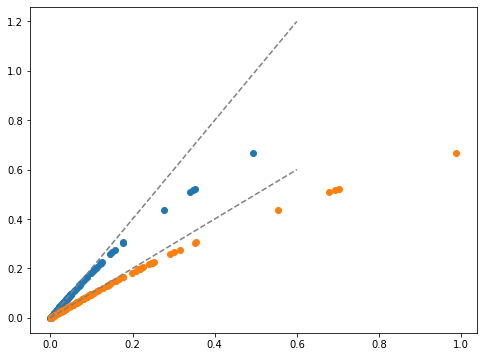

In [84]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(fsts_1kg, weir_fsts_1kg)
ax1.scatter(2*np.array(fsts_1kg), weir_fsts_1kg)
ax1.plot([0,0.6],[0,.6], color="gray", linestyle="--")
ax1.plot([0,0.6],[0,1.2], color="gray", linestyle="--")
plt.show()

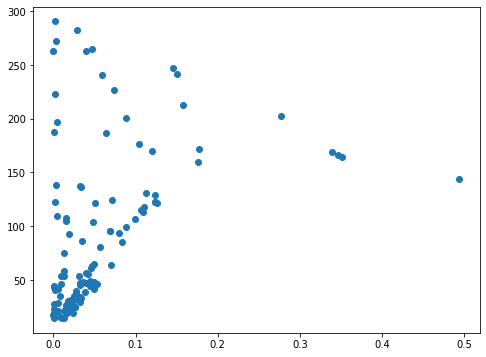

In [78]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(fsts_1kg, power_1kg)
plt.show()

## Try the same on GTEx data

In [135]:
# Use real genotype
chrm=9
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
# f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/ldpruned/GTEX_v8.SHAPEIT2_chr1.ldpruned.vcf.gz"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_noADM.sample"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
samplefile = None
gtfull, snpinfos, gt_donors = readgt.read_vcf(f_vcf, 0, 1000, samplefile=samplefile)

In [146]:
eursamples_noadm

['GTEX-111FC',
 'GTEX-117YW',
 'GTEX-1192W',
 'GTEX-11EI6',
 'GTEX-11EMC',
 'GTEX-11EQ8',
 'GTEX-11EQ9',
 'GTEX-11GS4',
 'GTEX-11GSO',
 'GTEX-11GSP',
 'GTEX-11NSD',
 'GTEX-11NUK',
 'GTEX-11O72',
 'GTEX-11OF3',
 'GTEX-11P81',
 'GTEX-11TTK',
 'GTEX-11TUW',
 'GTEX-11VI4',
 'GTEX-11XUK',
 'GTEX-11ZTT',
 'GTEX-11ZU8',
 'GTEX-11ZUS',
 'GTEX-11ZVC',
 'GTEX-1211K',
 'GTEX-1212Z',
 'GTEX-12584',
 'GTEX-12696',
 'GTEX-1269C',
 'GTEX-12C56',
 'GTEX-12KS4',
 'GTEX-12WSA',
 'GTEX-12WSE',
 'GTEX-12WSF',
 'GTEX-12WSG',
 'GTEX-12WSH',
 'GTEX-12WSI',
 'GTEX-12WSK',
 'GTEX-12WSL',
 'GTEX-12WSM',
 'GTEX-12ZZW',
 'GTEX-12ZZY',
 'GTEX-12ZZZ',
 'GTEX-13112',
 'GTEX-1313W',
 'GTEX-1314G',
 'GTEX-131XG',
 'GTEX-131XW',
 'GTEX-131YS',
 'GTEX-132AR',
 'GTEX-132NY',
 'GTEX-132Q8',
 'GTEX-1339X',
 'GTEX-133LE',
 'GTEX-1399Q',
 'GTEX-1399R',
 'GTEX-1399S',
 'GTEX-1399T',
 'GTEX-139D8',
 'GTEX-139T6',
 'GTEX-139TS',
 'GTEX-139TT',
 'GTEX-139TU',
 'GTEX-139YR',
 'GTEX-13CF2',
 'GTEX-13CF3',
 'GTEX-13CZU',
 'GTEX-13D

In [143]:
print(f"Eur: {len(eursamples_noadm)}")
print(f"Afr: {len(afr_samples)}")
eur_ix = [gt_donors.index(i) for i in eursamples_noadm]
afr_ix = [gt_donors.index(i) for i in afr_samples]

afr_n = len(eursamples)
eur_n = len(afr_samples)
all_n = afr_n + eur_n

eur_gt = gtfull[:, eur_ix]
afr_gt = gtfull[:, afr_ix]
all_gt = np.hstack((eur_gt, afr_gt))
print(all_gt.shape)

snp_info, dosage = readgt.filter_snps(snpinfos, all_gt)
eur_gt = dosage[:, :eur_n]
afr_gt = dosage[:, eur_n:]
all_gt = np.hstack((eur_gt, afr_gt))
print(dosage.shape)

Eur: 588
Afr: 103
(1000, 691)
Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of unknown allele symbol
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 1 SNPs because of low MAF (current)
(999, 691)


In [137]:
power_list = list()
fst_list = list()
for snpi,snp in enumerate(snp_info):
    #print(snp_info[snpi])
    maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
    maf_eur = sum(eur_gt[snpi,:] / 2 / len(eur_gt[snpi,:]))
    maf_afr = sum(afr_gt[snpi,:] / 2 / len(afr_gt[snpi,:]))

    c_eur = eur_n / all_n
    c_afr = afr_n / all_n
    p_all = maf_all*(1-maf_all)

    #print(maf_all, maf_eur, maf_afr)
    power = all_n * (c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) )

    Fst = (p_all  - ( c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) ) ) / p_all
    power_list.append(power)
    fst_list.append(2*Fst)
    #print(Fst*2)

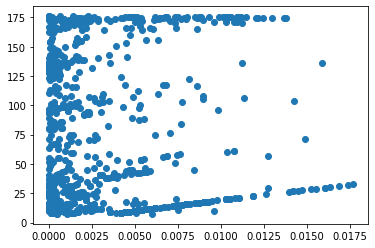

In [138]:
import matplotlib.pyplot as plt

plt.scatter(fst_list, power_list)
plt.show()

In [139]:
pops_gt = dict()
pops_gt["eur"] = eur_gt
pops_gt["afr"] = afr_gt
pops = ["eur", "afr"]
alleles = ["ref", "alt"]
fsts_gtex, power_gtex = calc_simple_fst_power(pops_gt, pops)
weir_fsts_gtex = weir_cockerman_fst(pops_gt, pops, alleles)

In [141]:
for i, snp in enumerate(snp_info):
    print(snp.varid, weir_fsts_gtex[i], fsts_gtex[i])

chr9_10536_C_T_b38 0.0022879334850578904 0.0012704788095398486
chr9_11110_C_T_b38 -0.00257461879496951 5.378675820682185e-05
chr9_11909_T_C_b38 -0.0018126242160366797 0.00024231458895383195
chr9_12896_G_A_b38 -0.0026944836467691366 2.713689783782804e-05
chr9_13953_A_G_b38 -0.0023018241662972317 0.0001284312517356375
chr9_13962_T_C_b38 -0.002193656674034418 0.00018654408552700602
chr9_14788_G_A_b38 -0.0006283123715736368 0.000546811852244904
chr9_38962_G_A_b38 -0.0018253674222694547 0.00024854901455907544
chr9_38985_C_T_b38 0.0006499032868816553 0.0008457241975405759
chr9_39212_A_C_b38 -0.0001375160312071949 0.0006463579188871664
chr9_39444_C_T_b38 0.0002438859505513926 0.0007453965606682265
chr9_39457_G_A_b38 -0.002639694740047933 7.532935409190423e-05
chr9_39486_G_A_b38 0.015885510154998683 0.004786599989264733
chr9_39516_C_T_b38 -0.0029379586830707728 1.8675283240390167e-05
chr9_39561_G_A_b38 0.012552081271022511 0.003858251256378931
chr9_39966_A_G_b38 -0.0018922975749151077 0.000290

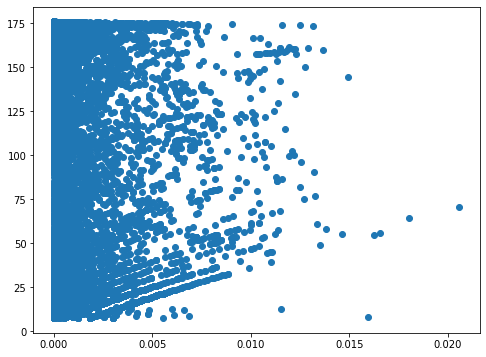

In [122]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(fsts_gtex, power_gtex)
plt.show()

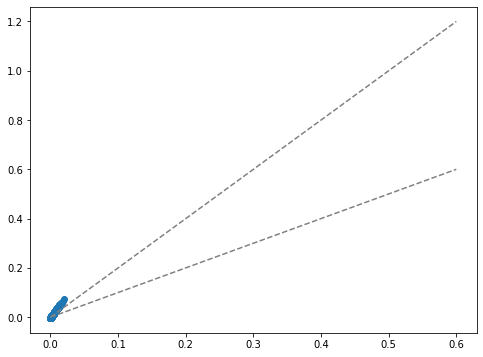

In [123]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(fsts_gtex, weir_fsts_gtex)
ax1.plot([0,0.6],[0,.6], color="gray", linestyle="--")
ax1.plot([0,0.6],[0,1.2], color="gray", linestyle="--")
plt.show()